In [1]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix

529
/media/work/docs/codes/QuCF/scripts-py


In [2]:
colors_ = ["b", "r", "g", "black", "orange"]
for i in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------
# --- Compact finite difference (CFD) method ---
# ---------------------------------------------------
def der_cfm(y, h, N):
    alpha, a1, a2 = 1./3, 7./9, 1./36, 
    beta1, beta2  = 3., 1./4
    g00, g01, g02, g03 = - 17./6, 3./2, 3./2, -1./6
    g10, g11, g12, g13 = - 3./4,   0.0, 3./4,   0.0
    
    # --- matrix A ---
    A = np.zeros([N, N])
    A[0,0], A[0,1]         = 1, beta1
    A[1,0], A[1,1], A[1,2] = beta2, 1, beta2
    A[N-2,N-3], A[N-2,N-2], A[N-2,N-1] = beta2, 1, beta2
    A[N-1,N-2], A[N-1,N-1]             = beta1, 1
    for ii in range(2, N-2):
        A[ii,ii-1], A[ii, ii], A[ii,ii+1] = alpha, 1, alpha
    A_inv = np.linalg.inv(A)
        
    # --- matrix B ---
    B = np.zeros([N, N])
    B[0,0], B[0,1], B[0,2], B[0,3] = g00, g01, g02, g03
    B[1,0], B[1,1], B[1,2], B[1,3] = g10, g11, g12, g13
    B[N-2,N-1], B[N-2,N-2], B[N-2,N-3], B[N-2,N-4] = -g10, -g11, -g12, -g13
    B[N-1,N-1], B[N-1,N-2], B[N-1,N-3], B[N-1,N-4] = -g00, -g01, -g02, -g03
    for ii in range(2, N-2):
        B[ii,ii-2],B[ii,ii-1], B[ii,ii+1], B[ii,ii+2] = -a2, -a1, a1, a2
    B = B/h
        
    C = np.dot(A_inv, B)
    y_der = np.dot(C,y)
    
    return y_der

In [ ]:
# --- For Test 1 ---
# dx:          4.000e-02, 4.000e-03, 4.000e-04
# max_abs_err: 1.876e-02, 2.979e-06, 3.229e-10
# 4-th order due to the boundaries

# --- For Test 2 ---
# dx:          4.000e-02, 4.000e-03, 4.000e-04
# max_abs_err: 5.534e-06, 5.484e-12, 3.197e-12
# 6-th order due to the CFD at bulk points, but at the boundaries, the function is close to zero

In [41]:
# ------------------------------------------------------
# --- Wave function with various boundary conditions ---
# > oscillating source at left boundary
# > right-propagating wave
# ------------------------------------------------------

def der_central_Neumann(y):
    y_der = np.zeros(Nx)
    for ii in range(1, Nx-1):
        y_der[ii] = y[ii+1] - y[ii-1]
    y_der = y_der/(2*dx)
    return y_der

def der_central_periodic(y):
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = y[ii+1] - y[Nx-1]
            continue
        if ii == (Nx - 1):
            y_der[ii] = y[0] - y[ii-1]
            continue
        y_der[ii] = y[ii+1] - y[ii-1]
    y_der = y_der/(2*dx)
    return y_der

def der_central_right_prop_open(y):
    y_der = np.zeros(Nx)
    for ii in range(Nx):
        if ii == 0:
            y_der[ii] = 0.
            continue
        if ii == (Nx - 1):
            y_der[ii] = 3. * y[Nx-1] - 4. * y[Nx-2] + y[Nx-3]
            continue
        y_der[ii] = y[ii+1] - y[ii-1]
    y_der = y_der/(2*dx)
    return y_der

def der_central_right_prop_open_CFD(y):
    y_der = der_cfm(y, dx, Nx)
    y_der[0] = 0
    return y_der

# -------------------------------------------------------

tmax, Nt = 4., 801 
xmax, Nx = 2., 201
v = 1. # can be nonuniform

t  = np.linspace(0, tmax, Nt)
dt = np.diff(t)[0]
x  = np.linspace(-xmax, xmax, Nx)
dx = np.diff(x)[0]
print("Courant number: {:0.3}".format(v * dt/ dx))

# --- signals ---
y = np.zeros((Nt, Nx))

# y[0,:] = np.exp(-x**2/(2*0.2**2))

# k = 2.*np.pi / (2.*xmax)
# y[0,:] = np.cos(k*x)

# --- chosen derivative method ---
der_y = lambda y, h, N: der_central_right_prop_open(y)

# --- source ---
y_source = np.zeros(Nt)
id_source = 0
T = 1.0
w = 2.*np.pi / T

ss = lambda t: np.sin(w * t)
# ss = lambda t: 0.

# --- reference simulations ---
dt2 = dt/2.
dt6 = dt/6.
for it in range(Nt-1):
    t1 = t[it]
    y_source[it] = ss(t1)

    # --- Step 1 ---
    RK_k1 = - v * der_y(y[it,:],              dx, Nx)
    RK_k1[id_source] += ss(t1)

    # --- Step 2 ---
    RK_k2 = - v * der_y(y[it,:] + dt2 * RK_k1, dx, Nx)  
    RK_k2[id_source] += ss(t1 + dt2)

    # --- Step 3 ---
    RK_k3 = - v * der_y(y[it,:] + dt2 * RK_k2, dx, Nx)  
    RK_k3[id_source] += ss(t1 + dt2)

    # --- Step 4 ---
    RK_k4 = - v * der_y(y[it,:] + dt * RK_k3,  dx, Nx)  
    RK_k4[id_source] += ss(t1 + dt)

    # --- Next time point ---
    y[it+1,:] = y[it,:] + dt/6. * (RK_k1 + 2.*RK_k2 + 2.*RK_k3 + RK_k4)
# ---
y_source[-1] = ss(t[Nt-1])

Courant number: 0.25


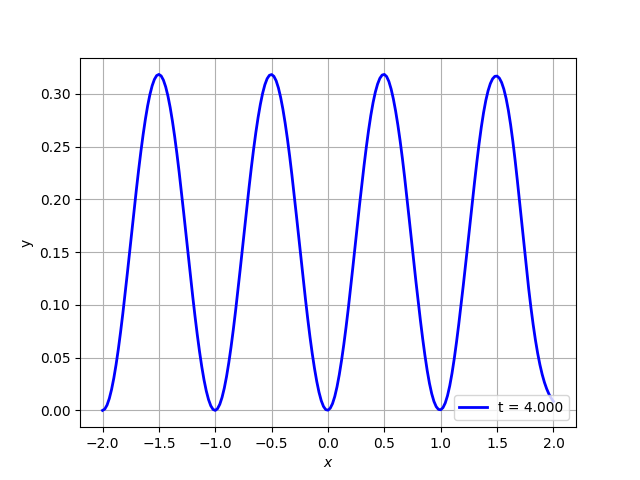

In [46]:
# ------------------------------------------------------------------
# --- Plotting the wave at various time moments ---
# ------------------------------------------------------------------
# t_moments = [0, 50, 60]
# t_moments = [120, 140, 160]
# t_moments = 2 * np.array([100, 200, 300])
t_moments = np.array([800])
# t_moments = [0]
# t_moments = [0,1]

fig = plt.figure()
ax = fig.add_subplot(111)
for it in range(len(t_moments)):
    id_t = t_moments[it]
    ax.plot(
        x, y[id_t, :], 
        color=colors_[it], linewidth = 2, linestyle='-',  
        label = "t = {:0.3f}".format(t[id_t])
    )
plt.xlabel('$x$')
plt.ylabel("y")
ax.legend()
plt.grid(True)
plt.show()

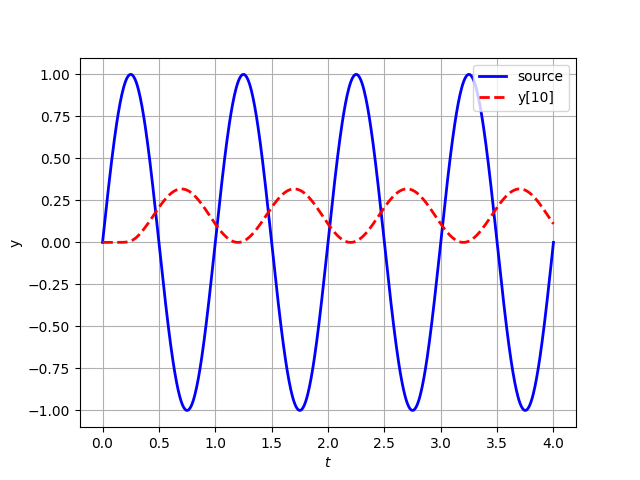

In [48]:
# ------------------------------------------------------------------
# --- Plotting time evolution at one space point ---
# ------------------------------------------------------------------
id_x_chosen = id_source+10

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t, y_source[:],       "b", linewidth = 2, linestyle='-',  label = "source")
ax.plot(t, y[:, id_x_chosen], "r", linewidth = 2, linestyle='--', label = "y[{:d}]".format(id_x_chosen))
plt.xlabel('$t$')
plt.ylabel("y")
ax.legend()
plt.grid(True)
plt.show()

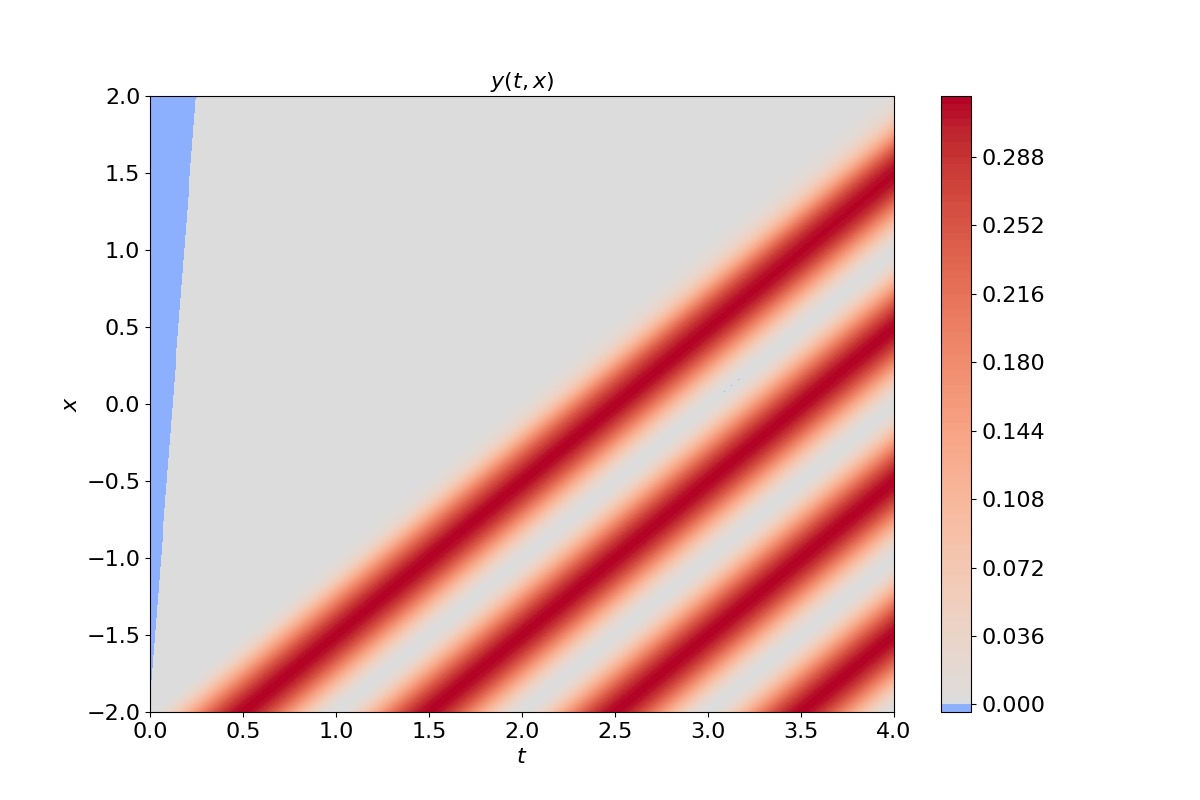

In [43]:
# -----------------------------------------------
# --- Plot(t,x) ---
# -----------------------------------------------
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vcenter=0.)

cmap_two_signs_= 'coolwarm'
fontsize = 16
linewidth = 4


# --- Plotting ---
XX, YY = np.meshgrid(t, x)
fig_tx = plt.figure(figsize=(12, 8))
ax = fig_tx.add_subplot(111)
cs = ax.contourf(XX, YY, np.transpose(y), levels=100, cmap=cmap_two_signs_, norm=divnorm)
cb = fig_tx.colorbar(cs, ax = ax)
cb.ax.ticklabel_format(style="scientific")
cb.ax.tick_params(labelsize=fontsize) 
ax.set_xlabel('$t$', fontsize = fontsize)
ax.set_ylabel('$x$', fontsize = fontsize)
ax.set_title('$y(t,x)$', fontsize = fontsize)
# ax.set_xlim(0, t_max)
# ax.set_ylim(-x_max, x_max)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
del fontsize, fig_tx


In [ ]:
# --------------------------------------------------------------
# --- Testing CFD method: derivatives ---
# --------------------------------------------------------------
xmax, Nx = 2., 101
x = np.linspace(-xmax, xmax, Nx)
dx = np.diff(x)[0]

# # --- Test 1 ---
# kw = 10.
# y_test = np.cos(kw * x)
# y_der_ref = -kw * np.sin(kw * x)

# --- Test 2 ---
kw = 0.2
y_test = np.exp(-x**2/(2.*kw**2))
y_der_ref = - x/(kw**2) * y_test

# --- CFD derivative ---
y_der_cfd = der_cfm(y_test, dx, Nx)

# --- Error ---
err = np.zeros(Nx)
for ii in range(Nx):
    temp = np.abs(y_der_ref[ii] - y_der_cfd[ii])
    if temp < 1e-16:
        temp = 1e-16
    err[ii] = np.log10(temp)

# ---- Plot derivatives ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_der_ref, color='b', linewidth = 2, linestyle='-',  label = "ref")
ax.plot(x, y_der_cfd, color='r', linewidth = 2, linestyle='--', label = "CFD")
plt.xlabel('$x$')
plt.ylabel("der")
ax.legend()
plt.grid(True)
plt.show()

# ---- Plot error ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, err, color='b', linewidth = 2, linestyle='-',  label = "ref")
plt.xlabel('$x$')
plt.ylabel("log10|err|")
ax.legend()
plt.grid(True)
plt.show()

# --- Printing some results ---
print("dx = {:0.3e}".format(dx))
print("max. |err|: {:0.3e}".format(np.max(np.abs(y_der_ref - y_der_cfd))))

In [52]:
# # ------------------------------------------------------
# # --- Wave function with various boundary conditions ---
# # ------------------------------------------------------
# tmax, Nt = 4., 401 
# xmax, Nx = 2., 101
# v = 1. # can be nonuniform

# t = np.linspace(0, tmax, Nt)
# dt = np.diff(t)[0]
# x = np.linspace(-xmax, xmax, Nx)
# dx = np.diff(x)[0]
# print("Courant number: {:0.3}".format(v * dt/ dx))

# # velocity profile
# v_prof = np.zeros(Nx)
# for ii in range(Nx):
#     v_prof[ii] = v

# # ---signal ---
# y = np.zeros((Nt, Nx))

# # --- initial conditions ---
# # kw = 10.
# # y[0,:] = np.cos(kw*x)

# # --- source ---
# kw = 0.2
# w = 10.0
# y_source = np.exp(-x**2/(2.*kw**2))

# # --- reference simulations ---
# vhtx = dt/(2.*dx) * v_prof
# q = Nx - 1
# for it in range(Nt-2):
#     y[it+1,0] = y[it,0] + vhtx[0] * (-3. * y[it,0] + 4. * y[it,1  ] - y[it,2]) \
#         + y_source[0] * np.cos(w * t[it])
#     y[it+1,q] = y[it,q] + vhtx[q] * ( 3. * y[it,q] - 4. * y[it,q-1] + y[it,q-2]) \
#         + y_source[q] * np.cos(w * t[it])
#     for ix in range(Nx):
#         if ix == 0:
#             temp = -3. * y[it,ix] + 4. * y[it,ix+1] - y[it,ix+2]
#         elif ix == (Nx - 1):
#             temp =  3. * y[it,ix] - 4. * y[it,ix-1] + y[it,ix-2]
#         else:
#             temp = y[it,ix+1] - y[it,ix-1]
#         y[it+1,ix] = y[it,ix] + vhtx[ix] * temp + y_source[ix] * np.cos(w * t[it])


# # vhtx = dt/(2.*dx) * v_prof
# # q = Nx - 1
# # for it in range(Nt-1):
# #     y[it+1,0] = y[it,0] + vhtx[0] * (-3. * y[it,0] + 4. * y[it,1  ] - y[it,2])
# #     y[it+1,q] = y[it,q] + vhtx[q] * ( 3. * y[it,q] - 4. * y[it,q-1] + y[it,q-2])
# #     for ix in range(1,q):
# #         y[it+1,ix] = y[it,ix] + vhtx[ix] * (y[it,ix+1] - y[it,ix-1])


# # for it in range(Nt-1):
# #     y_der = der_cfm(y[it,:], dx, Nx)
# #     y[it+1,:] = y[it,:] + v * dt * y_der

Courant number: 0.25
